In [4]:
import queue
import numpy as np
from typing import List, Tuple
import heapq
import math
import datetime

In [5]:
class Node:
    def __init__(self, path: List[int], cost: int, adjency_matrix: np.ndarray):
        self.path = path
        self.cost = cost
        self.level = len(path) - 1
        self.adjency_matrix = adjency_matrix
        self.bound = self.calculate_bound()
        
    def __lt__(self, other):
        return self.bound < other.bound

    def calculate_bound(self):
        lb = self.cost
        for city in range(self.adjency_matrix.shape[0]):
            if city in self.path:
                continue
            min_in = float('inf')
            min_out = float('inf')
            for other in range(self.adjency_matrix.shape[0]):
                if other in self.path or other == city:
                    continue
                min_out = min(min_out, self.adjency_matrix[city][other])
                min_in = min(min_in, self.adjency_matrix[other][city])
            lb += (min_out + min_in)/2
        return lb
        
    
    def __repr__(self):
        return f"Node(level={self.level}, path={self.path}, cost={self.cost})"
    
    def __str__(self):
        return f"Node(level={self.level}, path={self.path}, cost={self.cost})"

In [ ]:
def get_greedy_solution(adjency_matrix: np.ndarray, start_node: int) -> Tuple[List[int], int]:
    n = len(adjency_matrix)
    
    visited = [False] * n
    visited[start_node] = True
    
    path = [start_node]
    current = start_node
    total_cost = 0

    for _ in range(n - 1):
        next_city = min(
            [(i, adjency_matrix[current][i]) for i in range(n) if not visited[i]],
            key=lambda x: x[1]
        )[0]
        total_cost += adjency_matrix[current][next_city]
        path.append(next_city)
        visited[next_city] = True
        current = next_city

    total_cost += adjency_matrix[current][start_node]
    path.append(start_node)
    return path, total_cost

def branch_and_bound(adjency_matrix, start_node: int, percent_survive:float=0.5, max_survive_amount:int|None=20) -> Tuple[List[int], int]:
    adjency_matrix = np.array(adjency_matrix)
    n = adjency_matrix.shape[0]
    greedy_path, greedy_cost = get_greedy_solution(adjency_matrix, start_node)    
    
    best_path = greedy_path
    best_cost = greedy_cost
    
    initial_node = Node(path=[start_node], cost=0, adjency_matrix=adjency_matrix)
    
    queue = []
    heapq.heappush(queue, initial_node)
    
    while len(queue) > 0:
        current_node = heapq.heappop(queue)
        
        if len(current_node.path) == n:
            total_cost = current_node.cost + adjency_matrix[current_node.path[-1]][start_node]
            if total_cost < best_cost:
                best_cost = total_cost
                best_path = current_node.path + [start_node]
            continue
        
        new_nodes = []
        for next_city in range(n):
            if next_city in current_node.path:
                continue 
            
            new_path = current_node.path + [next_city]
            new_cost = current_node.cost + adjency_matrix[current_node.path[-1]][next_city]
            
            new_node = Node(path=new_path, cost=new_cost, adjency_matrix=adjency_matrix)
            
            if new_node.bound < best_cost:
                new_nodes.append(new_node)
        
        percent_amount = int(len(new_nodes)*percent_survive)
        amount = percent_amount if max_survive_amount is None else min(max_survive_amount, percent_amount)
        new_nodes = sorted(new_nodes, key=lambda x: x.bound)[:amount]
        for nn in new_nodes:
            heapq.heappush(queue, nn)
                
    return best_path, best_cost
    

In [7]:
class RandomNumberGenerator:
    def __init__(self, seedVaule=None):
        self.__seed=seedVaule
    def nextInt(self, low, high):
        m = 2147483647
        a = 16807
        b = 127773
        c = 2836
        k = int(self.__seed / b)
        self.__seed = a * (self.__seed % b) - k * c;
        if self.__seed < 0:
            self.__seed = self.__seed + m
        value_0_1 = self.__seed
        value_0_1 =  value_0_1/m
        return low + int(math.floor(value_0_1 * (high - low + 1)))
    def nextFloat(self, low, high):
        low*=100000
        high*=100000
        val = self.nextInt(low,high)/100000.0
        return val

In [8]:
random_gen = RandomNumberGenerator(123456789)

def create_adjency_matrix(n: int) -> np.ndarray:
    adjency_matrix = np.zeros((n, n), dtype=int)
    for i in range(n):
        for j in range(n):
            adjency_matrix[i][j] = random_gen.nextInt(1, 30)
    return adjency_matrix

In [9]:
import pandas as pd


reps = 5
sizes = range(2, 14, 1)

results = []
for size in sizes:
    for i in range(reps):
        m = create_adjency_matrix(size)
        start_time = datetime.datetime.now()
        path, cost = branch_and_bound(m, 0)
        end_time = datetime.datetime.now()
        elapsed_time = (end_time - start_time).total_seconds()
        results.append([m.shape[0], elapsed_time, cost])
        
        print(f"n={m.shape[0]} || r={i} || time={elapsed_time:.4}s")
        
        df = pd.DataFrame(results, columns=["Size", "TimeSeconds", "Cost"])
        df.to_csv("res/b_and_b_beam.csv", index=False)

n=2 || r=0 || time=0.0s
n=2 || r=1 || time=0.0s
n=2 || r=2 || time=0.0s
n=2 || r=3 || time=0.0s
n=2 || r=4 || time=0.0s
n=3 || r=0 || time=0.0s
n=3 || r=1 || time=0.0s
n=3 || r=2 || time=0.01443s
n=3 || r=3 || time=0.0s
n=3 || r=4 || time=0.0s
n=4 || r=0 || time=0.0s
n=4 || r=1 || time=0.0s
n=4 || r=2 || time=0.0s
n=4 || r=3 || time=0.0s
n=4 || r=4 || time=0.0s
n=5 || r=0 || time=0.0s
n=5 || r=1 || time=0.0s
n=5 || r=2 || time=0.0s
n=5 || r=3 || time=0.0s
n=5 || r=4 || time=0.0s
n=6 || r=0 || time=0.001674s
n=6 || r=1 || time=0.0s
n=6 || r=2 || time=0.0s
n=6 || r=3 || time=0.0s
n=6 || r=4 || time=0.0s
n=7 || r=0 || time=0.008002s
n=7 || r=1 || time=0.0s
n=7 || r=2 || time=0.0s
n=7 || r=3 || time=0.0s
n=7 || r=4 || time=0.005356s
n=8 || r=0 || time=0.01117s
n=8 || r=1 || time=0.0s
n=8 || r=2 || time=0.01903s
n=8 || r=3 || time=0.01572s
n=8 || r=4 || time=0.0s
n=9 || r=0 || time=0.0506s
n=9 || r=1 || time=0.01541s
n=9 || r=2 || time=0.001945s
n=9 || r=3 || time=0.03033s
n=9 || r=4 || tim

+------+-------+------+
| Size | Time  | Cost |
+------+-------+------+
| 2.0  |  0.0  | 29.4 |
| 3.0  | 0.003 | 36.4 |
| 4.0  |  0.0  | 41.0 |
| 5.0  |  0.0  | 47.6 |
| 6.0  |  0.0  | 62.4 |
| 7.0  | 0.003 | 62.6 |
| 8.0  | 0.009 | 75.0 |
| 9.0  | 0.025 | 66.6 |
| 10.0 | 0.121 | 74.2 |
| 11.0 | 0.51  | 79.4 |
| 12.0 | 1.775 | 86.2 |
| 13.0 | 7.94  | 85.8 |
+------+-------+------+


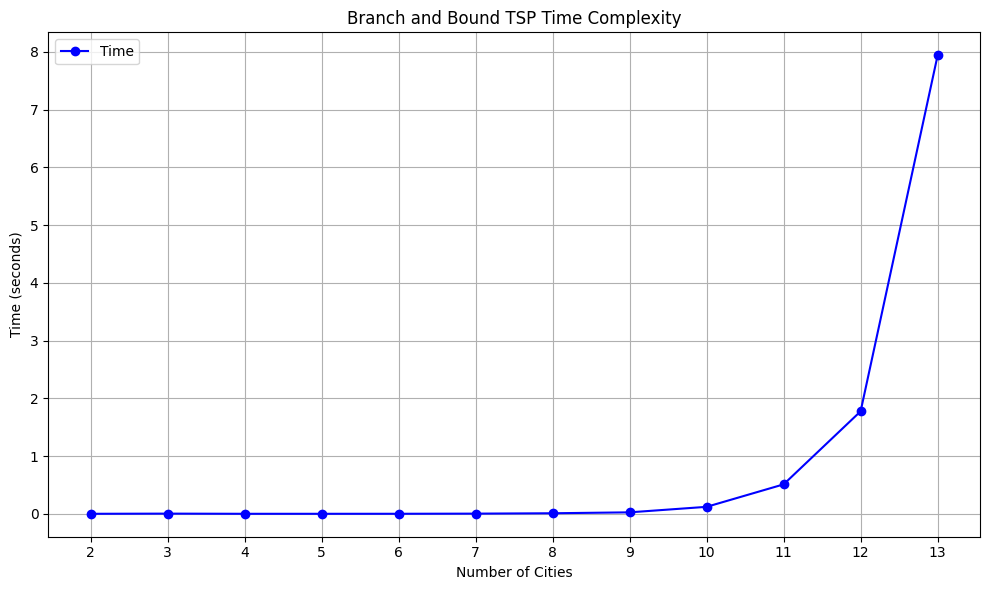

In [11]:
import matplotlib
from matplotlib import pyplot as plt
from tabulate import tabulate

df = pd.read_csv("res/b_and_b_beam.csv")

df_grouped = df.groupby(["Size"]).agg(
    Size =("Size", "first"),
    Time = ("TimeSeconds", "mean"),
    Cost = ("Cost", "mean"),
    ).reset_index(drop=True)

df_grouped.to_csv("res/b_and_b_beam_grouped.csv", index=False)
tmp = df_grouped.copy().round(3)
print(tabulate(tmp, headers='keys', tablefmt='pretty', showindex=False))


plt.figure(figsize=(10, 6))

plt.plot(df_grouped["Size"], df_grouped["Time"], marker='o', linestyle='-', color='b', label="Time")

plt.title("Branch and Bound TSP Time Complexity")
plt.xlabel("Number of Cities")
plt.ylabel("Time (seconds)")
plt.legend()
plt.xticks(df_grouped["Size"])
plt.grid(True)
plt.tight_layout()
# plt.savefig('res/b_and_b.png')
plt.show()